In [17]:
import pandas as pd
import os
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from datetime import datetime
import time
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '../../Pokemon-data/'
NORMALIZED_DATA = '../../Training-baseline/'
SEED = 42
BATCH_SIZE = 64
EPOCHS = 20
PRETRAINED = True
MODEL_NAME = str(EPOCHS) + "Epochs-freeze"
checkpoint_path = './saved-models/'
n_epochs_stop = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
metadata = pd.read_csv('metadata/pokemon.csv')

pokemon_names = [x for x in os.listdir(NORMALIZED_DATA)]

filtered_metadata = metadata[metadata.name.isin(pokemon_names)]

filtered_list = filtered_metadata.loc[:,'name'].tolist()

filtered_metadata = filtered_metadata.loc[:,['name', 'type1']]

#fire_data = filtered_metadata[filtered_metadata["type1"] == 'fire']
#grass_data = filtered_metadata[filtered_metadata["type1"] == 'grass']
#filtered_metadata = pd.concat([fire_data, grass_data], ignore_index=True)

filtered_metadata.type1 = pd.Categorical(filtered_metadata.type1)
filtered_metadata['code'] = filtered_metadata.type1.cat.codes
print(filtered_metadata['code'])

def compile_training_data_to_list():
    all_data = []
    for pokemon in os.listdir(NORMALIZED_DATA):
        all_data += [pokemon + '/' + x for x in os.listdir(NORMALIZED_DATA + pokemon)]

    results = create_annotated_dataframe(all_data)
    return results

def create_annotated_dataframe(all_data):
    base_data = {'file_name': [], 'name': [], 'label': []}
    for item in all_data:
        if len(filtered_metadata[filtered_metadata['name'].str.contains(item.split('/')[0])]):
            base_data['file_name'].append(item)
            base_data['name'].append(item.split('/')[0])
            # yes, this is a bit ugly, but we have to match with the metadata
            base_data['label'].append(
                filtered_metadata[
                    filtered_metadata['name']==(item.split('/')[0])
                ].loc[:,'code'].tolist()[0])

    results, y_train = create_encoded_dataframe(base_data)
    return results, y_train

def create_encoded_dataframe(base_data):
    results = pd.DataFrame(base_data, columns = ['file_name', 'name', 'label'])
    labels = np.unique(results["label"])
    max_value = np.max(labels) + 1
    Y_train = np.eye(max_value)[results["label"]]
    return results, Y_train

0       9
1       9
2       9
3       6
4       6
       ..
714     7
715     4
716     1
718    15
720     6
Name: code, Length: 703, dtype: int8


In [4]:
encoded_data, y_train = compile_training_data_to_list()

In [5]:
class CustomDataset(Dataset):
	def __init__(self, x, y, img_dir):
		self.x = x
		self.y = y
		self.img_dir = img_dir
		self.classes = np.unique(self.y)


	def __len__(self):
		return len(self.x)


	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.x[idx])
        # use the slice to remove a possible 4th alpha channel
		#image = iio.v2.imread(img_path)[:,:,:3]
		image = np.load(img_path)[:,:,:3]
		image = image.astype(np.float32)
		label = self.y[idx]
		return image, label

In [6]:
def stratified_split(dataset, labels):
    x_train, x_val, y_train, y_val = train_test_split(dataset['file_name'].to_numpy(),
                                                  labels,
                                                  test_size=0.25,
                                                  stratify=dataset['label'],
                                                  random_state=SEED)

    trainSet = CustomDataset(x_train, y_train, NORMALIZED_DATA)
    valSet = CustomDataset(x_val, y_val, NORMALIZED_DATA)
    return trainSet, valSet

In [7]:
def print_performance_metrics(currentEpoch, avgTrainLoss, trainCorrect, avgValLoss, valCorrect, trainf1, valf1):
    print()
    print(f"[INFO] EPOCH: {currentEpoch + 1}/{EPOCHS}")
    print(f"Train loss: {avgTrainLoss :.6f}, Train accuracy: {trainCorrect :.4f}")
    print(f"Val loss: 	{avgValLoss :.6f}, Val accuracy:   {valCorrect :.4f}")
    print(f"Train F1: 	{trainf1 :.6f}")
    print(f"Val F1: 	{valf1 :.6f}")
    print(f"---------------------------------------------------- \n")

In [8]:
train, val = stratified_split(encoded_data, y_train)
trainDataLoader = DataLoader(train, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(val, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [9]:
from torchvision import models
model = models.efficientnet_b0(pretrained=True)

In [10]:
for param in model.parameters():
    param.requires_grad = False

In [11]:
import torch.nn as nn
# Add on classifier
model.classifier = nn.Sequential(
                      nn.Linear(1280, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.5),
                      nn.Linear(256, 18),                   
                      nn.LogSoftmax(dim=1))

In [12]:
model = model.to('cuda')

In [13]:
torch.manual_seed(SEED)
class_acc = []
epochs_no_improve = 0
metrics = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": [],
	"trainf1": [],
    "valf1": []
}

In [14]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [15]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

for epoch in range(EPOCHS):
    print(f"[INFO] starting training for epoch: {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}")

    train_preds = []
    train_target = []

    val_preds = []
    val_target = []

    model.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    min_val_loss = 100

    for data, targets in tqdm(trainDataLoader, desc="Training progress"):
        data = data.transpose(1, 3)
        data = data.transpose(2, 3)

        data = data.float()
        data, targets = (data.to(device), targets.to(device))
        # Generate predictions
        out = model(data)
        # Calculate loss
        loss = criterion(out, targets)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss

        for item in out:
            train_preds.append(np.argmax(item.cpu().detach().numpy()))
            trainCorrect += (item.argmax(0) == targets.argmax(0)).type(torch.float).sum().item()

        for label in targets:
            train_target.append(label.cpu().detach().numpy().argmax(0))

    with torch.no_grad():
        model.eval()
        print(f"[INFO] starting evaluation for epoch: {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}")
        for data, targets in tqdm(valDataLoader, desc="Validation progress"):
            data = data.transpose(1, 3)
            data = data.transpose(2, 3)

            data = data.float()
            data, targets = (data.to(device), targets.to(device))
            # Generate predictions
            out = model(data)
            # Calculate loss
            totalValLoss += criterion(out, targets)
            for item in out:
                val_preds.append(np.argmax(item.cpu().detach().numpy()))
                valCorrect += (item.argmax(0) == targets.argmax(0)).type(torch.float).sum().item()

            for label in targets:
                val_target.append(label.cpu().detach().numpy().argmax(0))

        # Average validation loss
        avg_val_loss = totalValLoss / valSteps
        # If the validation loss is at a minimum
        if avg_val_loss < min_val_loss:
            # Save the model
            torch.save(model, checkpoint_path + MODEL_NAME + ".pt")
            epochs_no_improve = 0
            min_val_loss = avg_val_loss

        else:
            epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!')

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps

    # calculate per class accuracy via confusion matrix
    matrix = confusion_matrix(val_target, val_preds)
    class_acc.append(matrix.diagonal() / matrix.sum(axis=1))

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)

    # calculate macro F1 score
    trainf1 = f1_score(train_target, train_preds, average='macro')
    valf1 = f1_score(val_target, val_preds, average="macro")

    # update our training history
    metrics["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    metrics["train_acc"].append(trainCorrect)
    metrics["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    metrics["val_acc"].append(valCorrect)
    metrics['trainf1'].append(trainf1)
    metrics['valf1'].append(valf1)

    # print the model training and validation information
    print_performance_metrics(epoch, avgTrainLoss, trainCorrect, avg_val_loss, valCorrect, trainf1, valf1)

endTime = time.time()
print(f"[INFO] total time taken to train the model: {(endTime - startTime) / 60 :.2f}min")

[INFO] training the network...
[INFO] starting training for epoch: 1 at 14:46:59


Training progress: 100%|██████████| 142/142 [03:40<00:00,  1.56s/it]


[INFO] starting evaluation for epoch: 1 at 14:50:40


Validation progress: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]



[INFO] EPOCH: 1/20
Train loss: 2.635387, Train accuracy: 0.6144
Val loss: 	2.414669, Val accuracy:   0.5437
Train F1: 	0.132817
Val F1: 	0.217097
---------------------------------------------------- 

[INFO] starting training for epoch: 2 at 14:51:12


Training progress: 100%|██████████| 142/142 [03:34<00:00,  1.51s/it]


[INFO] starting evaluation for epoch: 2 at 14:54:47


Validation progress: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]



[INFO] EPOCH: 2/20
Train loss: 2.846840, Train accuracy: 0.6080
Val loss: 	2.842153, Val accuracy:   0.5344
Train F1: 	0.168498
Val F1: 	0.195139
---------------------------------------------------- 

[INFO] starting training for epoch: 3 at 14:55:19


Training progress: 100%|██████████| 142/142 [03:35<00:00,  1.52s/it]


[INFO] starting evaluation for epoch: 3 at 14:58:55


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]



[INFO] EPOCH: 3/20
Train loss: 3.275739, Train accuracy: 0.4608
Val loss: 	3.469286, Val accuracy:   0.5815
Train F1: 	0.167921
Val F1: 	0.184214
---------------------------------------------------- 

[INFO] starting training for epoch: 4 at 14:59:27


Training progress: 100%|██████████| 142/142 [03:31<00:00,  1.49s/it]


[INFO] starting evaluation for epoch: 4 at 15:02:58


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]



[INFO] EPOCH: 4/20
Train loss: 3.634405, Train accuracy: 0.4413
Val loss: 	3.581786, Val accuracy:   0.4901
Train F1: 	0.162326
Val F1: 	0.171827
---------------------------------------------------- 

[INFO] starting training for epoch: 5 at 15:03:30


Training progress: 100%|██████████| 142/142 [03:34<00:00,  1.51s/it]


[INFO] starting evaluation for epoch: 5 at 15:07:05


Validation progress: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]



[INFO] EPOCH: 5/20
Train loss: 3.578528, Train accuracy: 0.4369
Val loss: 	4.491843, Val accuracy:   0.4483
Train F1: 	0.142214
Val F1: 	0.156847
---------------------------------------------------- 

[INFO] starting training for epoch: 6 at 15:07:38


Training progress: 100%|██████████| 142/142 [03:29<00:00,  1.47s/it]


[INFO] starting evaluation for epoch: 6 at 15:11:08


Validation progress: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]



[INFO] EPOCH: 6/20
Train loss: 4.380521, Train accuracy: 0.3782
Val loss: 	4.406511, Val accuracy:   0.4060
Train F1: 	0.137590
Val F1: 	0.153756
---------------------------------------------------- 

[INFO] starting training for epoch: 7 at 15:11:40


Training progress: 100%|██████████| 142/142 [03:26<00:00,  1.46s/it]


[INFO] starting evaluation for epoch: 7 at 15:15:07


Validation progress: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]



[INFO] EPOCH: 7/20
Train loss: 4.489189, Train accuracy: 0.3652
Val loss: 	5.901306, Val accuracy:   0.3954
Train F1: 	0.126700
Val F1: 	0.128608
---------------------------------------------------- 

[INFO] starting training for epoch: 8 at 15:15:40


Training progress: 100%|██████████| 142/142 [03:44<00:00,  1.58s/it]


[INFO] starting evaluation for epoch: 8 at 15:19:24


Validation progress: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]



[INFO] EPOCH: 8/20
Train loss: 4.552035, Train accuracy: 0.3697
Val loss: 	7.318829, Val accuracy:   0.4483
Train F1: 	0.121664
Val F1: 	0.137264
---------------------------------------------------- 

[INFO] starting training for epoch: 9 at 15:19:56


Training progress: 100%|██████████| 142/142 [03:29<00:00,  1.47s/it]


[INFO] starting evaluation for epoch: 9 at 15:23:26


Validation progress: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]



[INFO] EPOCH: 9/20
Train loss: 4.562896, Train accuracy: 0.3785
Val loss: 	7.518887, Val accuracy:   0.4281
Train F1: 	0.117799
Val F1: 	0.114575
---------------------------------------------------- 

[INFO] starting training for epoch: 10 at 15:23:59


Training progress: 100%|██████████| 142/142 [03:25<00:00,  1.44s/it]


[INFO] starting evaluation for epoch: 10 at 15:27:24


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]



[INFO] EPOCH: 10/20
Train loss: 4.611739, Train accuracy: 0.3670
Val loss: 	7.305721, Val accuracy:   0.4046
Train F1: 	0.108870
Val F1: 	0.112673
---------------------------------------------------- 

[INFO] starting training for epoch: 11 at 15:27:55


Training progress: 100%|██████████| 142/142 [03:24<00:00,  1.44s/it]


[INFO] starting evaluation for epoch: 11 at 15:31:20


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]



[INFO] EPOCH: 11/20
Train loss: 4.830123, Train accuracy: 0.3560
Val loss: 	7.836319, Val accuracy:   0.4113
Train F1: 	0.104714
Val F1: 	0.111835
---------------------------------------------------- 

[INFO] starting training for epoch: 12 at 15:31:52


Training progress: 100%|██████████| 142/142 [03:24<00:00,  1.44s/it]


[INFO] starting evaluation for epoch: 12 at 15:35:17


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]



[INFO] EPOCH: 12/20
Train loss: 4.848828, Train accuracy: 0.3535
Val loss: 	8.187554, Val accuracy:   0.3907
Train F1: 	0.100456
Val F1: 	0.100731
---------------------------------------------------- 

[INFO] starting training for epoch: 13 at 15:35:48


Training progress: 100%|██████████| 142/142 [03:25<00:00,  1.44s/it]


[INFO] starting evaluation for epoch: 13 at 15:39:14


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]



[INFO] EPOCH: 13/20
Train loss: 5.307231, Train accuracy: 0.3407
Val loss: 	9.180634, Val accuracy:   0.3775
Train F1: 	0.093873
Val F1: 	0.091542
---------------------------------------------------- 

[INFO] starting training for epoch: 14 at 15:39:45


Training progress: 100%|██████████| 142/142 [03:27<00:00,  1.46s/it]


[INFO] starting evaluation for epoch: 14 at 15:43:13


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]



[INFO] EPOCH: 14/20
Train loss: 5.250139, Train accuracy: 0.3451
Val loss: 	10.331482, Val accuracy:   0.3649
Train F1: 	0.097779
Val F1: 	0.087761
---------------------------------------------------- 

[INFO] starting training for epoch: 15 at 15:43:45


Training progress: 100%|██████████| 142/142 [03:24<00:00,  1.44s/it]


[INFO] starting evaluation for epoch: 15 at 15:47:09


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]



[INFO] EPOCH: 15/20
Train loss: 6.483773, Train accuracy: 0.3405
Val loss: 	11.217552, Val accuracy:   0.3748
Train F1: 	0.095730
Val F1: 	0.087720
---------------------------------------------------- 

[INFO] starting training for epoch: 16 at 15:47:41


Training progress: 100%|██████████| 142/142 [03:34<00:00,  1.51s/it]


[INFO] starting evaluation for epoch: 16 at 15:51:16


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]



[INFO] EPOCH: 16/20
Train loss: 5.767329, Train accuracy: 0.3463
Val loss: 	12.499501, Val accuracy:   0.3940
Train F1: 	0.098987
Val F1: 	0.095036
---------------------------------------------------- 

[INFO] starting training for epoch: 17 at 15:51:47


Training progress: 100%|██████████| 142/142 [03:26<00:00,  1.45s/it]


[INFO] starting evaluation for epoch: 17 at 15:55:14


Validation progress: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]



[INFO] EPOCH: 17/20
Train loss: 5.472059, Train accuracy: 0.4279
Val loss: 	12.945220, Val accuracy:   0.3685
Train F1: 	0.094745
Val F1: 	0.093231
---------------------------------------------------- 

[INFO] starting training for epoch: 18 at 15:55:47


Training progress: 100%|██████████| 142/142 [03:26<00:00,  1.45s/it]


[INFO] starting evaluation for epoch: 18 at 15:59:13


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]



[INFO] EPOCH: 18/20
Train loss: 8.944761, Train accuracy: 0.4295
Val loss: 	11.968962, Val accuracy:   0.3722
Train F1: 	0.095501
Val F1: 	0.089878
---------------------------------------------------- 

[INFO] starting training for epoch: 19 at 15:59:45


Training progress: 100%|██████████| 142/142 [03:25<00:00,  1.44s/it]


[INFO] starting evaluation for epoch: 19 at 16:03:10


Validation progress: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]



[INFO] EPOCH: 19/20
Train loss: 8.283300, Train accuracy: 0.3336
Val loss: 	13.732991, Val accuracy:   0.3821
Train F1: 	0.091548
Val F1: 	0.086654
---------------------------------------------------- 

[INFO] starting training for epoch: 20 at 16:03:41


Training progress: 100%|██████████| 142/142 [03:27<00:00,  1.46s/it]


[INFO] starting evaluation for epoch: 20 at 16:07:09


Validation progress: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]



[INFO] EPOCH: 20/20
Train loss: 7.796072, Train accuracy: 0.3418
Val loss: 	13.533423, Val accuracy:   0.3801
Train F1: 	0.098039
Val F1: 	0.083987
---------------------------------------------------- 

[INFO] total time taken to train the model: 80.72min


In [16]:
print(metrics)

{'train_loss': [array(2.63538726), array(2.84683959), array(3.27573885), array(3.63440507), array(3.57852762), array(4.38052145), array(4.48918943), array(4.55203504), array(4.56289561), array(4.61173886), array(4.83012252), array(4.84882835), array(5.30723118), array(5.25013924), array(6.48377291), array(5.76732875), array(5.47205897), array(8.9447606), array(8.28330018), array(7.79607222)], 'train_acc': [0.6144166022739816, 0.608014129594878, 0.460757257975494, 0.44132906501821395, 0.4369135666188321, 0.3781874379070538, 0.36516171762887734, 0.36968760348824375, 0.3785186002870074, 0.3670383044486146, 0.35599955845016007, 0.3534606468705155, 0.34065570151230823, 0.34507119991169005, 0.34054531405232363, 0.34628546197152005, 0.42786179490009935, 0.42951760679986756, 0.3335909040732973, 0.3417595761121537], 'val_loss': [array(2.41466872), array(2.84215349), array(3.46928591), array(3.58178582), array(4.49184346), array(4.40651052), array(5.90130615), array(7.3188289), array(7.51888664)

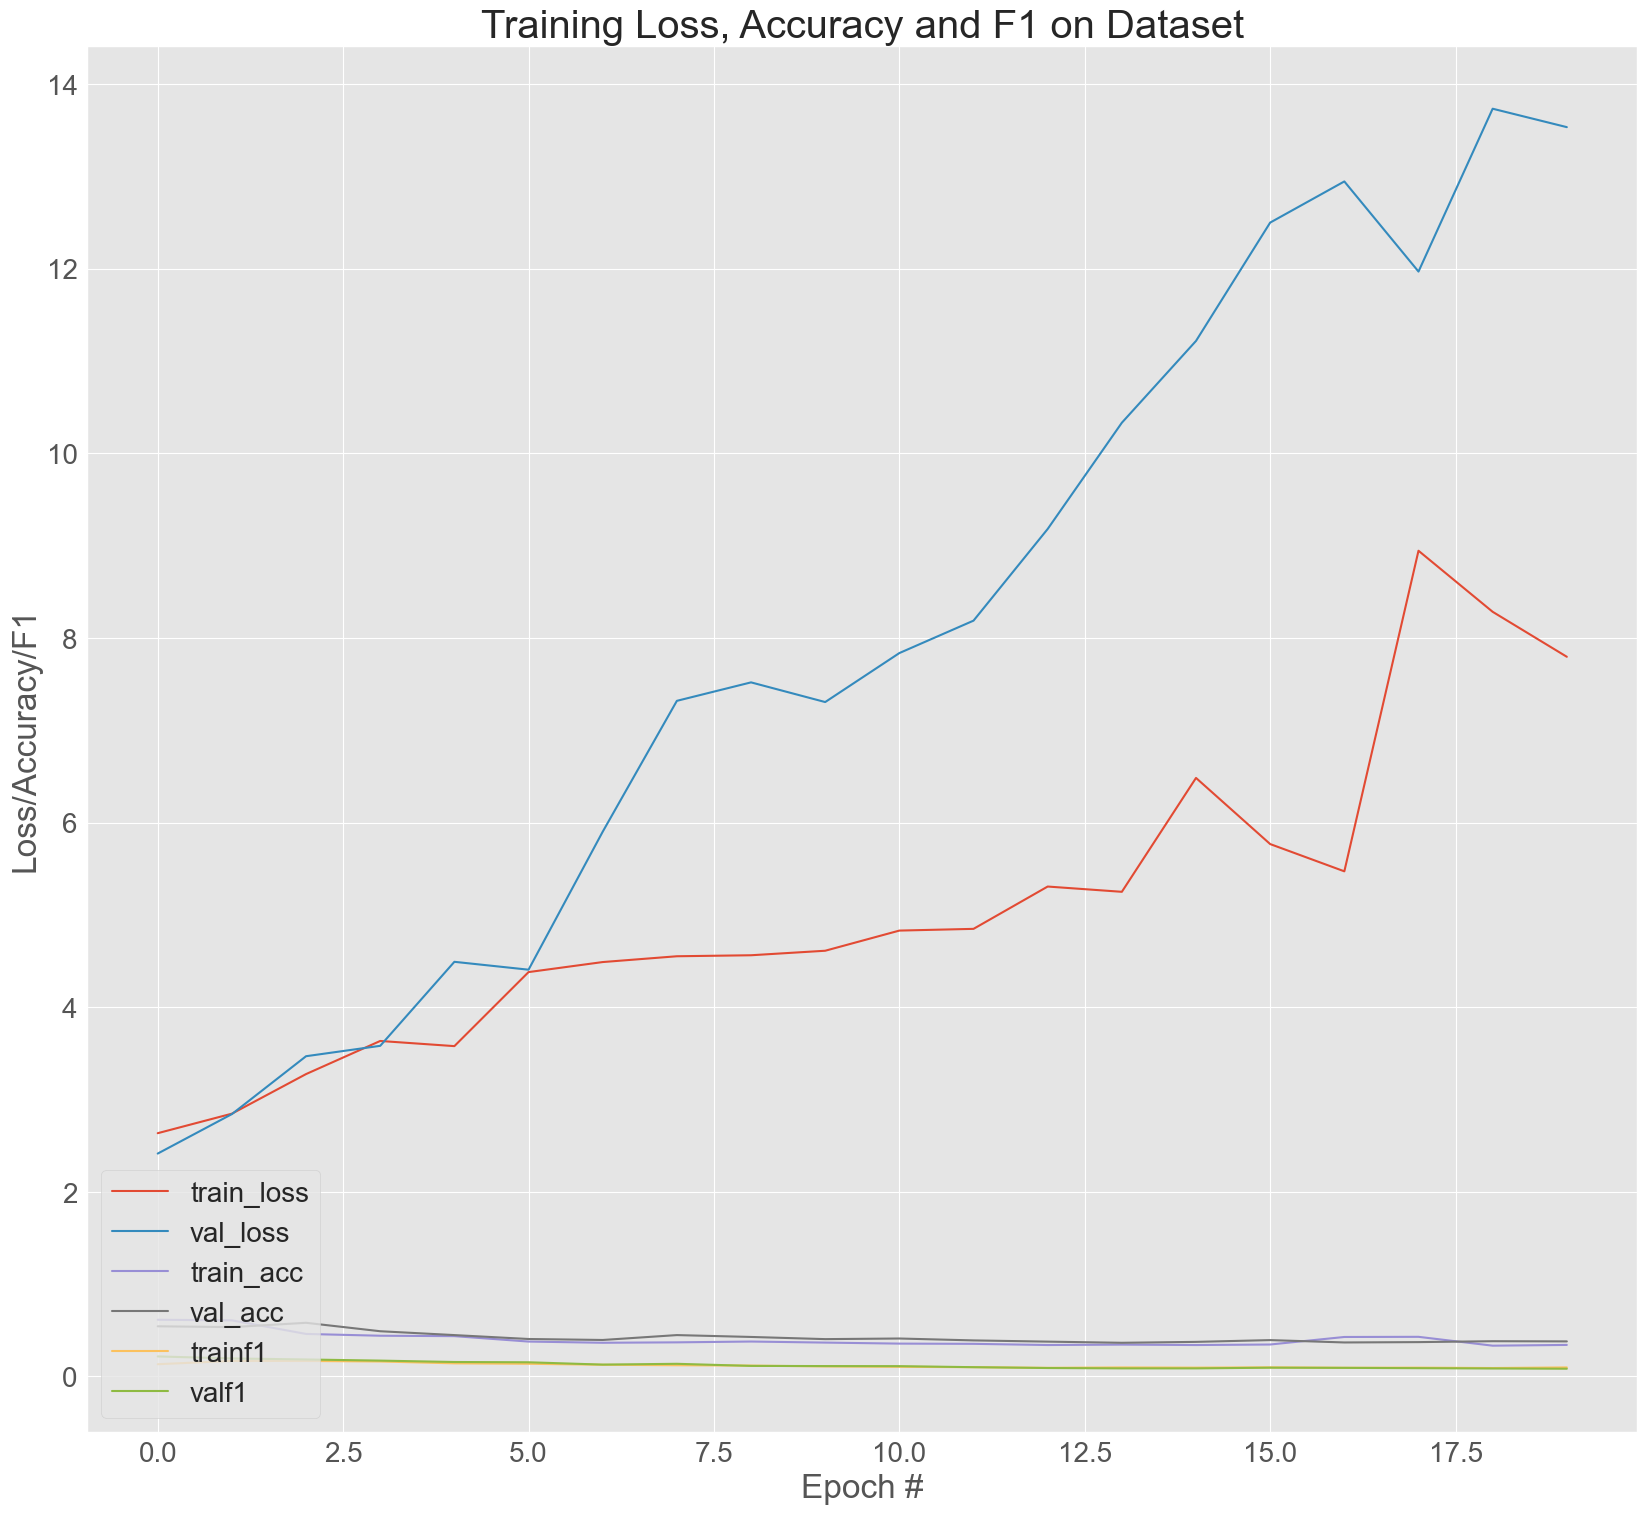

In [18]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.rcParams['font.size'] = 20
plt.figure(figsize=(20, 18))
plt.plot(metrics["train_loss"], label="train_loss")
plt.plot(metrics["val_loss"], label="val_loss")
plt.plot(metrics["train_acc"], label="train_acc")
plt.plot(metrics["val_acc"], label="val_acc")
plt.plot(metrics["trainf1"], label="trainf1")
plt.plot(metrics["valf1"], label="valf1")
plt.title("Training Loss, Accuracy and F1 on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/F1")
plt.legend(loc="lower left")